In [100]:
import pandas as pd
import numpy as np
import scipy.stats as st
from scipy.optimize import minimize

T = ['AAPL','NVDA','MSFT','GOOGL','AMZN','META','TSLA','AVGO','BRK/B','LLY']; P=52
full = pd.read_excel("spx_returns_weekly.xlsx","s&p500 rets").rename(columns={'BRK.B':'BRK/B','BRK-B':'BRK/B'})
bench = pd.read_excel("spx_returns_weekly.xlsx","benchmark rets")
full['date'] = pd.to_datetime(full['date']); bench['date']=pd.to_datetime(bench['date'])
df = full[['date']+T].merge(bench[['date','SPY']],on='date').set_index('date').apply(pd.to_numeric,errors='coerce').dropna()



In [101]:
cov = df.cov() * 52
cov.to_numpy()
mean = df.mean() * 52
mean.to_numpy()
TARGET_MEAN = 0.2

In [102]:
def objective(w):        
    return (w.T @ cov @ w)

def fun_constraint_capital(w):
    return np.sum(w) - 1


def fun_constraint_mean(w):
    return (mean @ w) - TARGET_MEAN

In [103]:
def portfolio_stats(weights, mean, cov):
    port_mean = np.dot(weights, mean)
    port_vol = np.sqrt(weights @ cov @ weights)
    port_sharpe = port_mean / port_vol
    return port_mean, port_vol, port_sharpe

In [104]:
constraint_capital = {'type': 'eq', 'fun': fun_constraint_capital}
constraint_mean = {'type': 'eq', 'fun': fun_constraint_mean}
bounds = [[-0.2, 0.35]] * len(mean)
constraints = ([constraint_capital, constraint_mean])

weights = np.ones(len(mean)) / len(mean)
results = minimize(objective, weights, constraints=constraints, bounds = bounds)
results.x = results.x / sum(results.x)
weights = pd.Series(results.x, index=mean.index)
mu, vol, sharpe = portfolio_stats(weights, mean, cov)
print("Contrained Weights")
display(weights)
print("Porttfolio Mean")
display(mu)
print("Portfolio Volatlity")
display(vol)
display("Portfolio Sharpe")
display(sharpe)

Contrained Weights


AAPL     0.029241
NVDA    -0.014344
MSFT     0.144508
GOOGL    0.009064
AMZN     0.093858
META     0.002874
TSLA    -0.015071
AVGO     0.036250
BRK/B    0.350000
LLY      0.213085
SPY      0.150535
dtype: float64

Porttfolio Mean


0.199999999998153

Portfolio Volatlity


0.16488914935836244

'Portfolio Sharpe'

1.2129360893449832

In [105]:
asset_vol = np.sqrt(df.var() * 52)
asset_sharpe = mean / asset_vol
print("Asset Means")
display(mean)
print("Asset Sharpes")
display(asset_sharpe)
print("Constrained Weights")
display(weights)

Asset Means


AAPL     0.238714
NVDA     0.645580
MSFT     0.261402
GOOGL    0.216800
AMZN     0.293447
META     0.261924
TSLA     0.469754
AVGO     0.394854
BRK/B    0.135025
LLY      0.281542
SPY      0.131264
dtype: float64

Asset Sharpes


AAPL     0.862938
NVDA     1.393490
MSFT     1.089266
GOOGL    0.774698
AMZN     0.958976
META     0.745509
TSLA     0.801039
AVGO     1.052574
BRK/B    0.708223
LLY      0.994919
SPY      0.768182
dtype: float64

Constrained Weights


AAPL     0.029241
NVDA    -0.014344
MSFT     0.144508
GOOGL    0.009064
AMZN     0.093858
META     0.002874
TSLA    -0.015071
AVGO     0.036250
BRK/B    0.350000
LLY      0.213085
SPY      0.150535
dtype: float64

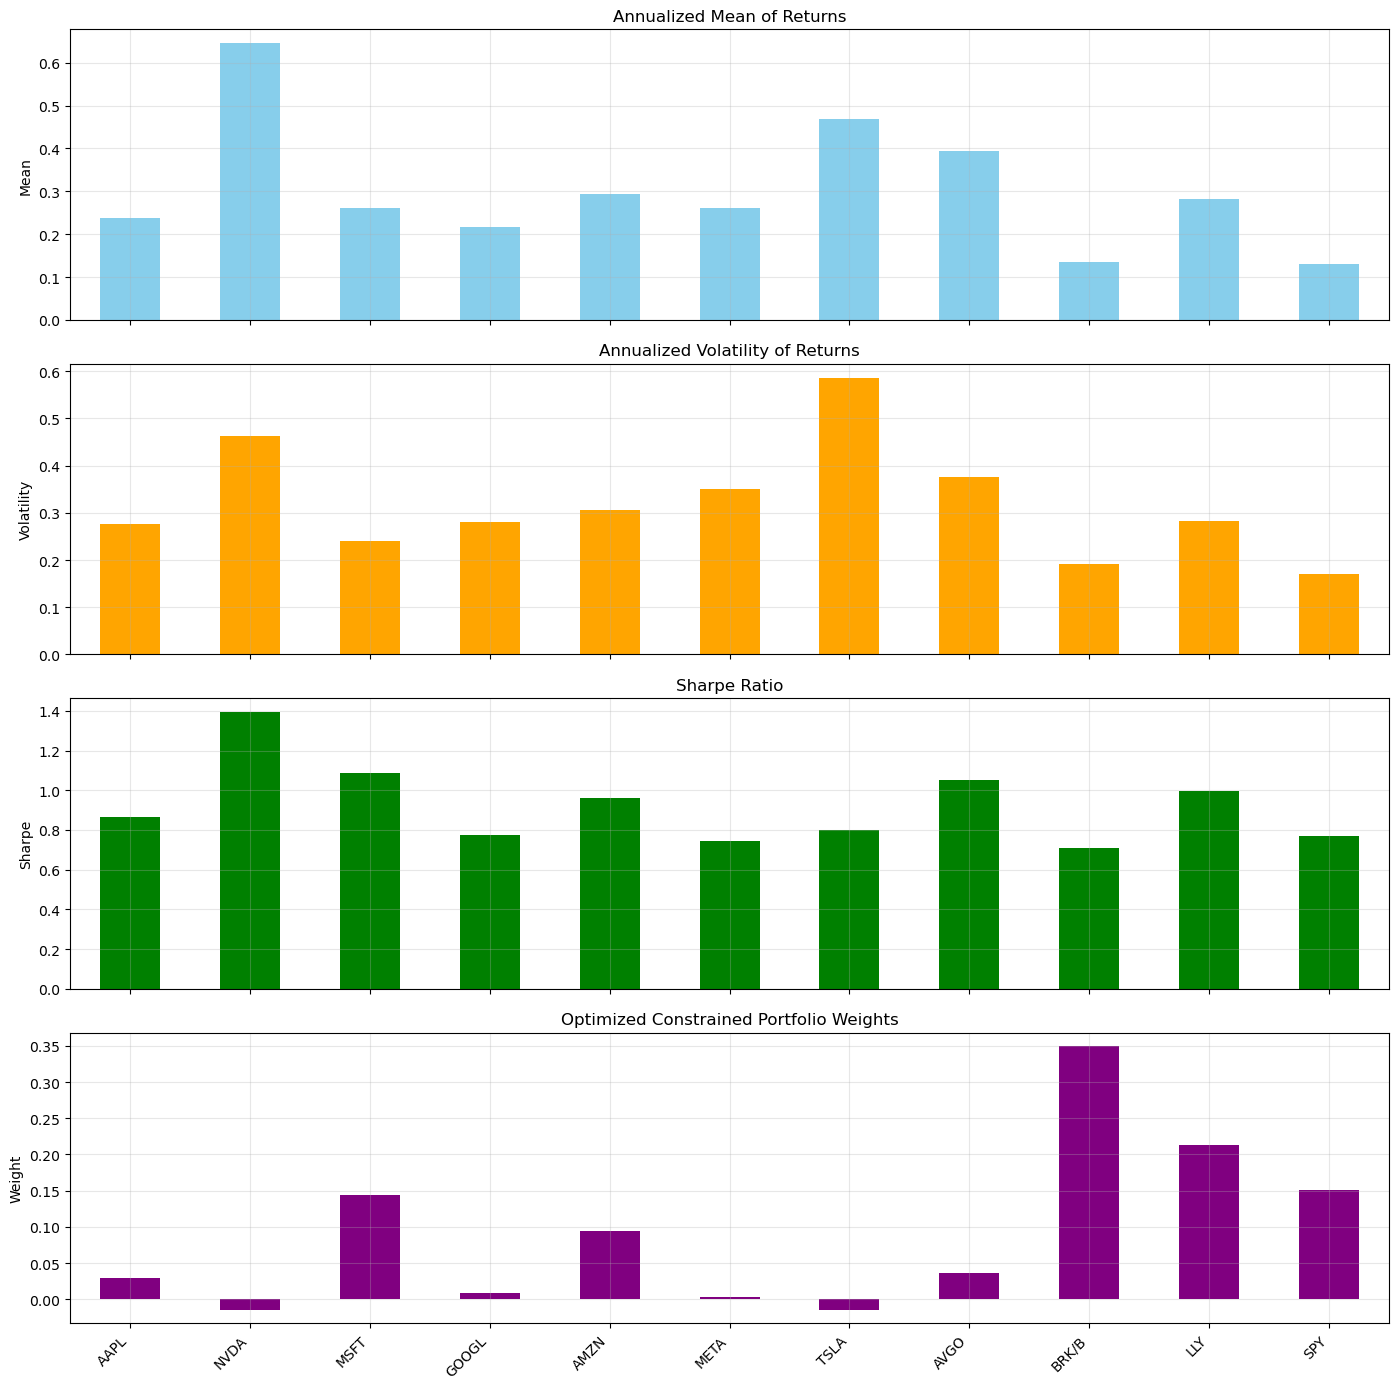

In [106]:
import matplotlib.pyplot as plt
import pandas as pd


summary = pd.DataFrame({
    "Annual Mean": mean,
    "Annual Volatility": asset_vol,
    "Sharpe Ratio": asset_sharpe,
    "Constrained Weight": weights
})


fig, axes = plt.subplots(4, 1, figsize=(14, 14), sharex=True)


summary["Annual Mean"].plot(kind="bar", ax=axes[0], color="skyblue")
axes[0].set_title("Annualized Mean of Returns")
axes[0].set_ylabel("Mean")


summary["Annual Volatility"].plot(kind="bar", ax=axes[1], color="orange")
axes[1].set_title("Annualized Volatility of Returns")
axes[1].set_ylabel("Volatility")


summary["Sharpe Ratio"].plot(kind="bar", ax=axes[2], color="green")
axes[2].set_title("Sharpe Ratio")
axes[2].set_ylabel("Sharpe")


summary["Constrained Weight"].plot(kind="bar", ax=axes[3], color="purple")
axes[3].set_title("Optimized Constrained Portfolio Weights")
axes[3].set_ylabel("Weight")


for ax in axes:
    ax.grid(alpha=0.3)
    ax.set_xlabel("")  

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


It appears that there is almost no correlation between the magnitude of an asset's sharpe and its weights. There is a slight negative correlation between an asset's mean and its weights, with BRK/B, LLY, and SPY having the three largest weights yet all have relatively small means (same for NVDA and TSLA with high means but low weights). This could be due to the inequality contraints on the weights, as well as the target return of 20% being closer to the low-end of this asset universe

Unbounded Portfolio Weights


AAPL     0.409367
NVDA     0.882896
MSFT     0.848584
GOOGL    0.193126
AMZN     0.426356
META     0.277408
TSLA     0.310150
AVGO     0.601896
BRK/B    2.580474
LLY      1.112630
SPY     -6.642887
dtype: float64

,Portfolio,Mean (ann.),Vol (ann.),Sharpe
0,Unbounded,1.302228,0.629539,2.068541
1,Constrained,0.200000,0.164889,1.212936


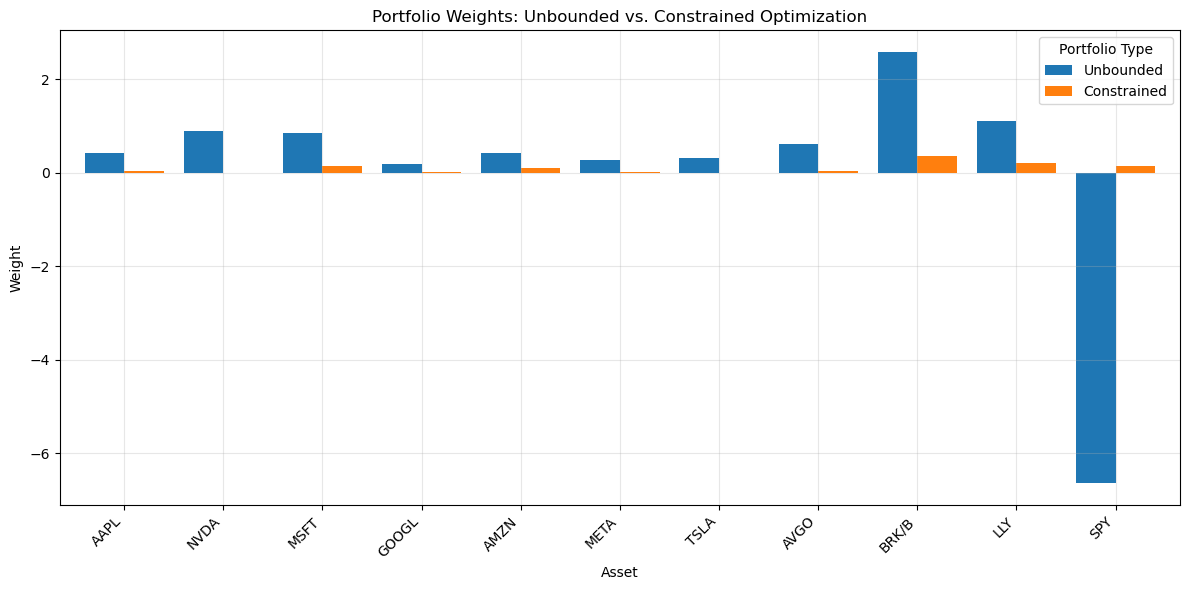

In [107]:
eye = np.eye(cov.shape[0])
inv = np.linalg.solve(cov, eye)
unbounded_weights = inv @ mean
unbounded_weights = unbounded_weights /  sum(unbounded_weights)
unbounded_weights = pd.Series(unbounded_weights, index=mean.index)
print("Unbounded Portfolio Weights")
display(unbounded_weights)
unbounded_mean, unbounded_vol, unbounded_sharpe = portfolio_stats(unbounded_weights, mean, cov)

stats = pd.DataFrame({
    "Portfolio": ["Unbounded", "Constrained"],
    "Mean (ann.)": [unbounded_mean, mu],
    "Vol (ann.)": [unbounded_vol, vol],
    "Sharpe": [unbounded_sharpe, sharpe]
})
display(stats)

compare = pd.DataFrame({
    "Unbounded": unbounded_weights,
    "Constrained": weights
})

compare.plot(kind='bar', figsize=(12,6), width=0.8)
plt.title("Portfolio Weights: Unbounded vs. Constrained Optimization")
plt.ylabel("Weight")
plt.xlabel("Asset")
plt.grid(alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.legend(title="Portfolio Type")
plt.tight_layout()
plt.show()